# Ejercicio 3 b. Traducción Automática de Texto

Este ejercicio tiene como objetivo entrenar un modelo para traducción automática de texto (neural machine translation) del inglés a español. Para ello, haremos uso de redes recurrentes y word embeddings. 

![neural machine translation](img/nmt.png)

## 1. Enunciado

La traducción de texto se suele realizar con modelos de tipo sequence-to-sequence, donde existe un *encoder* que codifica el lenguaje de entrada, y un *decoder* que genera el texto en el lenguaje de salida. Actualmente esto se realiza empleando redes con auto-atención (transformers), pero para este ejercicio vamos a implementar una red recurrente clásica. 

La implementación del modelo recurrente la puedes realizar basándote en los ejemplos:
1. [Modelo sequence-to-sequence a nivel de caracteres con LSTM](https://keras.io/examples/nlp/lstm_seq2seq/): Este ejemplo de Keras muestra cómo entrenar un modelo seq-to-seq implementado con LSTMs para la traducción de inglés a francés. Está basado en esta antigua entrada del [blog de Keras](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html), donde también se dan las pistas para trabajar a nivel de palabras.
2. [Traducción de inglés a español con un transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/): Este ejemplo de Keras muestra como implementar un modelo seq-to-seq de tipo transformer en Keras, y cómo procesar el dataset de traducción de inglés al español con la capa `TextVectorization`.
3. [Traducción automática neuronal usando un modelo seq2seq a nivel de palabra](https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7): Este proyecto, cuyo código está disponible en este [repositorio de github](https://github.com/devm2024/nmt_keras), trabaja con un modelo seq-to-seq usando como tokens las palabras de las frases, para la traducción del inglés al francés. Incluye una capa de embedding vacía.

Tu trabajo consistirá en adaptar el código de los ejemplos anteriores para entrenar un modelo seq-to-seq basado en LSTMs para la traducción del inglés a español. Puedes tokenizar el texto con `Tokenizer` así como con `TextVectorization`, según te convenga mejor para construir las entradas. Sin embargo, debes utilizar una capa de word embedding pre-entrenada para inglés (Glove, Word2Vec...), como vimos en las prácticas. Es suficiente con entrenar tan solo un modelo de estas características.

*De forma opcional*, se valorará la comparativa del modelo obtenido con un modelo pre-entrenado de HuggingFace para la traducción de inglés al español con el dataset descargado. También se dará un punto extra se si usan métricas BLEU y ROUGE para comparar el rendimiento de los modelos.

**IMPORTANTE**: Se permiten cambios en el código para adaptarlo a la GPU empleada. Es posible que el modelo no se pueda cargar al completo en la GPU, por lo que se puede simplificar (usar un subconjunto más pequeño, un tamaño de batch más pequeño, etc.)

## 2. Entrega

La entrega de este ejercicio se realiza a través de la tarea creada para tal efecto en Enseñanza Virtual. Tienes que entregar un notebook, y el HTML generado a partir de él, cuyas celdas estén ya evaluadas.

La estructura del notebook debe contener los siguientes apartados:

0. Cabecera: nombre y apellidos.
1. Dataset: descripción, carga y procesado.
2. Selección y carga del word embedding para el inglés.
3. Modelo y configuración creadas en Keras y su entrenamiento. Debe incluir una explicación razonada de los componentes, y de la selección de valores como el número de unidades en las redes recurrentes (LSTM/GRU), dimensión del embedding, etc.
5. Análisis de resultados con comparativa respecto del trabajo original ([ejemplo 2](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)) basado en transformers (*no es necesario mejorarlo*). Si se hace la parte opcional (comparar con un modelo pre-entrenado de HuggingFace), indicar la comparativa. El análisis puede ser cualitativo, haciendo pruebas de texto. *Se evaluará con 1 punto extra si se hace un análisis con métricas como BLEU y ROUGE (se pueden usar desde KerasNLP).*
6. Bibliografía utilizada (enlaces web, material de clase, libros, etc.).

### 2.1. Nota importante
-----
**HONESTIDAD ACADÉMICA Y COPIAS: un trabajo práctico es un examen, por lo que
debe realizarse de manera individual. La discusión y el intercambio de
información de carácter general con los compañeros se permite (e incluso se
recomienda), pero NO AL NIVEL DE CÓDIGO. Igualmente el remitir código de
terceros, OBTENIDO A TRAVÉS DE LA RED o cualquier otro medio, se considerará
plagio.** 

**Cualquier plagio o compartición de código que se detecte significará
automáticamente la calificación de CERO EN LA ASIGNATURA para TODOS los
alumnos involucrados. Por tanto a estos alumnos NO se les conservará, para
futuras convocatorias, ninguna nota que hubiesen obtenido hasta el momento.
SIN PERJUICIO DE OTRAS MEDIDAS DE CARÁCTER DISCIPLINARIO QUE SE PUDIERAN
TOMAR.**

-----

## 3. Código para iniciarse

En el [ejemplo 2](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/) indicado anteriormente, se puede ver cómo descargar y procesar un dataset de traducción del inglés al español. Abajo se deja igualmente la celda para descargar y cargar el dataset (se puede evaluar las veces que haga falta, ya que se descarga tan solo una vez, y se almacena en el directorio $HOME/.keras).

In [1]:
from tensorflow import keras
import pathlib

text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"

El dataset viene en el siguiente formato: cada línea del fichero es una frase en inglés seguida por la correspondiente en español, separados por un tabulador. La siguiente celda separa cada frase en cada idioma, y además al español (idioma destino) le añade los tokens [start] y [end], necesarios para controlar la generación de la salida.

In [2]:
from pathlib import Path
import random
text_file = Path(text_file)

with open(text_file, 'r', encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]

    text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

In [3]:
for _ in range(5):
    print(random.choice(text_pairs))

("My driver's license expires at the end of this month.", '[start] Mi licencia de conducir expira a final de este mes. [end]')
("I'm dependable.", '[start] Soy confiable. [end]')
('She kept quiet.', '[start] Ella se quedó quieta. [end]')
('Tom wanted to meet you.', '[start] Tom quería conocerle. [end]')
('The glass shattered into pieces.', '[start] El vidrio se hizo trizas. [end]')


In [4]:
# Este código separa el conjunto de entrenamiento en train, val y test
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [5]:
print(train_pairs[0])

("I'm not sure I believe you.", '[start] No estoy seguro de que te crea. [end]')


## 4. Modelos tipo seq-to-seq con Teacher Forcing

Un modelo de tipo sequence-to-sequence (seq-to-seq, o simplemente, seq2seq), se caracterizan porque reciben como entrada secuencias (texto) y generan como salida otra secuencia (texto). En nuestro caso la entrada será una frase en inglés y la salida será la frase en español.

Estos modelos se caracterizan porque están divididos en dos partes: un *encoder* y un *decoder*. Estos dos modelos se componen de la siguiente forma para conformar el modelo seq2seq (también conocido como *teacher forcing*):

![neural machine translation](img/seq2seq-teacher-forcing.png)


* El **encoder**:
  * **Recibe** la *secuencia de entrada* (frase en inglés). Cada token será una palabra, y se usará su representación con un word embedding pre-entrenado (Glove, Word2vec, FastText ...).
  * **Devuelve** el *estado oculto* de la última neurona de la red recurrente, que sirve como continuación para el decoder. Si es una LSTM, será el último hidden state y el cell state.
* El **decoder**:
  * **Recibe**:
    * El *último estado oculto (hidden state, cell state)* generado en el encoder.
    * La *secuencia de salida*, incluyendo el [start]. 
  * **Devuelve** la secuencia de salida desplazada en 1 posición. Si la frase original es "[start] Hablé con Tom [end]", la salida será "Hablé con Tom [end]".
  
La configuración del decoder es así porque se empleará en tiempo de inferencia de forma *auto-regresiva*; es decir: empezamos con tan solo "[start]", y el decoder generará la siguiente palabra (por ejemplo, "hablé"); esta palabra se concatena a la solución parcial, teniendo "[start] hablé"; se repite el proceso, le damos al decoder esa solución parcial y dará la siguiente palabra (por ejemplo, "con"), y la añadimos a la solución parcial "[start] hablé con", y así hasta alcanzar el token [end]. 
  
Recuerda que la salida del modelo indicará en formato one-hot cual es la siguiente palabra. Las entradas (del encoder y del decoder) serán las secuencias de los tokens en formato one-hot (que después pasarán por la correspondiente capa de embedding, siendo para el inglés un embedding pre-entrenado).


# <center> Cabecera: nombre y apellidos. </center>

## Alfonso Alarcón Tamayo

# <center> Dataset: descripción, carga y procesado. </center>

El conjunto que vamos a trabajar es un conjunto de frases en ingles seguidas de su traducción de español,vamos a cargar los datos , tokemizarlos y ver la frecuencia de estos.

In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import string
import re
import numpy as np
import pathlib
import random


import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras.layers import TextVectorization
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.utils import plot_model

from keras.models import Model
from keras.layers import Embedding
from keras.utils import plot_model
from keras.layers import Input, LSTM, Embedding, Dense

Antes de hacer la vectorización vamos a comprobar el número de palabras medio de las frases llamando a lines (lines es una combinacion de la palabra en inglés seguida de la de español) así que el resultado debe ser aproximadamente la mitad


En este caso podemos ver que el valor de las frases son unas 40 palabras por lo que cada frase tendra aproximadamente 20 palabras, así que vamos a definir la longitud máxima de las frases en 20, si es menor se hará padding para rellenar y si es mayor se recortará. Esto lo hago sobretodo por la falta de capacidad computacional y para no tardar demasiado tiempo en entrenar mi modelo

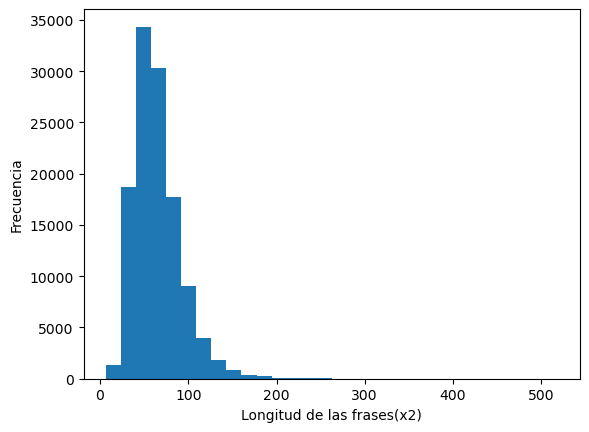

In [7]:
import matplotlib.pyplot as plt

sequence = [len(seq) for seq in lines]

# Mostramos los datos
plt.hist(sequence, bins=30)
plt.xlabel('Longitud de las frases(x2)')
plt.ylabel('Frecuencia')

plt.show()

Ahora toca vectorizar, para este apartado vamos a usar el mismo método que en el ejemplo 2 ya que hasta este punto es igual para nuestro trabajo

En primer lugar se han definido los caracteres a eliminar, los corchetes y el caracter "¿" que se encuentra solo en el idioma español

El método de custom_standardization sirve para pasar a minúsculas todos los elementos y reemplazar los caracteres de strip_chars (comas, signos de interrogación...)

Después se ha definido el vocabulario máximo (que es el mismo que he definido para el word embedding ,10000 palabras), el tamaño de la secuencia , que he comentado anteriormente el porque de este valor y el batch_size que lo he reducido a 32 para usar lotes más pequeños

Después hemos llamado a TextVectorizacion que es un método de keras que sirve para convertir secuencias de texto en secuencias de enteros


Finalmente generamos listas para cada valor y con el método adapt la usamos para que las capas  "aprenda" del conjunto de textos proporcionados.

In [8]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

vocab_size = 10000
sequence_length = 20
batch_size = 32

eng_vectorization = TextVectorization(max_tokens=vocab_size,output_mode="int",output_sequence_length=sequence_length,)

spa_vectorization = TextVectorization(max_tokens=vocab_size,output_mode="int",output_sequence_length=sequence_length + 1,standardize=custom_standardization,)


train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

Vamos a comprobar que la vectorizacion se ha realizado correctamente

In [9]:
import tensorflow as tf

# Tomar la primera frase de train_eng_texts
first_eng_text = train_eng_texts[0]

# Vectorizamos la primera frase del conjunto
vectorized_text_eng = eng_vectorization(tf.constant([first_eng_text]))

# Mostramos el resultado obtenido
print(f"Texto : {first_eng_text}")
print(f"Tokens: {vectorized_text_eng.numpy()[0]}")

Texto : I'm not sure I believe you.
Tokens: [ 34  33 232   3 220   5   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [10]:
# Tomar la primera frase de train español
first_spa_text = train_spa_texts[0]

# la vectorizamos
vectorized_text_spa = spa_vectorization(tf.constant([first_spa_text]))

# Mostramos el resultado obtenido
print(f"Texto : {first_spa_text}")
print(f"Tokens: {vectorized_text_spa.numpy()[0]}")

Texto : [start] No estoy seguro de que te crea. [end]
Tokens: [   2    7   37  208    4    5   28 6047    3    0    0    0    0    0
    0    0    0    0    0    0    0]


# <center> Selección y carga del word embedding para el inglés. </center>

Aqui lo que vamos a hacer ahora es cargar ya un modelo preentrenado para aprovecharnos de este, más concretamente usaremos glove, para cargar estos datos tenemos que descargar y descomprimir los archivos (en mi caso) en la carpeta de este proyecto

In [11]:
import numpy as np
glove_dir = 'glove.6B'

# El archivo esta en el mismo directorio
glove_path = 'glove.6B.100d.txt'

Ahora cargamos los vectores de glove y los incializamos, recorremos cada linea para obtener su palabra y su vector, y lo almacenamos en un diccionario embedding_index. Teniendo así por una parte la palabra y por otra como valores los coeficientes de esta.

In [12]:
import numpy as np

embedding_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

Ahora lo que vamos a hacer es crear la matrix que le vamos a cargar a la capa de inmersion, el tamaño de esta será de Max_words que son 10000 en nuestro caso y el embedim_dim que es 100, el vocabulario será el que hemos obtenido en eng_vectorization

In [13]:
embedding_dim = 100
embedding_matrix = np.zeros((10000, embedding_dim))

for i, word in enumerate(eng_vectorization.get_vocabulary()):
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Al crear el modelo tenemos que pasarle una capa embedding con el aprendizaje , abajo he especificado como quedaría al añadirla  al modelo 

In [14]:
# Capa de embedding con GloVe
glove_layer = Embedding(
    input_dim=vocab_size,  # tamaño del vocabulario =10000
    output_dim=embedding_dim,  # Dimensión del embedding = 100
    weights=[embedding_matrix],  # Pesos de la matriz definido anteriormente
    input_length=sequence_length,  # Longitud de la secuencias = 20
    trainable=False  # No queremos que se actualicen los pesos
)

# <center> Modelo y configuración creadas en Keras y su entrenamiento. Debe incluir una explicación razonada de los componentes, y de la selección de valores como el número de unidades en las redes recurrentes (LSTM/GRU), dimensión del embedding, etc. </center>

Para crear el modelo el caso más parecido es el del ejemplo 3 y también podemos ver el ejemplo 2, para ello vamos a tratar de adaptar el método para nuestros datos y para nuestro traductor inglés-español ya que en el ejemplo es del francés al inglés y no usa embedding mientrás que nosotros hemos definido una capa con los datos extraidos de glove

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten

# FIX mirar ejemplo 2 y 3
model = Sequential()

# Capa de Embedding
model.add(Embedding(
    input_dim=vocab_size,  # tamaño del vocabulario =10000
    output_dim=embedding_dim,  # Dimensión del embedding = 100
    weights=[embedding_matrix],  # Pesos de la matriz definido anteriormente
    input_length=sequence_length,  # Longitud de la secuencias = 20
    trainable=False  # No queremos que se actualicen los pesos
))

model.add(LSTM(50, return_sequences=True))  
model.add(LSTM(50)) 
model.add(Flatten())
model.add(Dense(32, activation='relu'))
# La última capa deberíia tener el num_decoder_tokens
model.add(Dense(1, activation='softmax'))


In [16]:
# Compilamos
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# Mostramos el modelo
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 lstm (LSTM)                 (None, 20, 50)            30200     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1052065 (4.01 MB)
Trainable params: 52065

# <center> Análisis de resultados con comparativa respecto del trabajo original (ejemplo 2) basado en transformers (no es necesario mejorarlo). Si se hace la parte opcional (comparar con un modelo pre-entrenado de HuggingFace), indicar la comparativa. El análisis puede ser cualitativo, haciendo pruebas de texto. Se evaluará con 1 punto extra si se hace un análisis con métricas como BLEU y ROUGE (se pueden usar desde KerasNLP). </center>

# <center> Bibliografía utilizada (enlaces web, material de clase, libros, etc.). </center>

https://keras.io/examples/nlp/neural_machine_translation_with_transformer/
    
https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7

https://keras.io/examples/nlp/lstm_seq2seq/